In [1]:
!wget -O face_detection_yunet_2022mar.onnx https://github.com/opencv/opencv_zoo/raw/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx
!wget -O model_classification.pt "https://storage.yandexcloud.net/jupyter.asciishell.ru/glass-resnet18-init=True-cls_w=0.5-bs=128/model_9.pt"
!wget -O faces.jpg "https://airat.biz/wp-content/uploads/group.jpg"

--2022-12-21 19:10:34--  https://github.com/opencv/opencv_zoo/raw/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/opencv/opencv_zoo/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx [following]
--2022-12-21 19:10:34--  https://media.githubusercontent.com/media/opencv/opencv_zoo/master/models/face_detection_yunet/face_detection_yunet_2022mar.onnx
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 345478 (337K) [application/octet-stream]
Saving to: ‘face_detection_yunet_2022mar.onnx’

face_detectio

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from cropp_image import YUNET_CROP
from glass_model import Model
from IPython.display import display
from PIL import Image
from torchvision import transforms

In [3]:
threshold = 0.1
model_name = "./model_classification.pt"

crop_model = YUNET_CROP(padding=(15, 15), score_threshold=0.85, nms_threshold=0.3)

model = Model(64, arch="resnet18")
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(model_name))
model.eval()


def draw_image_function(img):
    display(prepare_img(img))


def prepare_img(croped_img):
    r, g, b = Image.fromarray(np.uint8(croped_img)).split()
    return Image.merge("RGB", (b, g, r))


def predict_with_model(model, images):
    if isinstance(images, Image.Image):
        images = [images]
    images = [img.resize((224, 224), Image.Resampling.BILINEAR) for img in images]
    test_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        ]
    )
    images = torch.stack([test_transforms(img) for img in images], dim=0)
    with torch.no_grad():
        emb, proba = model(images)
    proba = scipy.special.softmax(proba, axis=1)
    return emb.cpu().numpy(), proba.cpu().numpy()

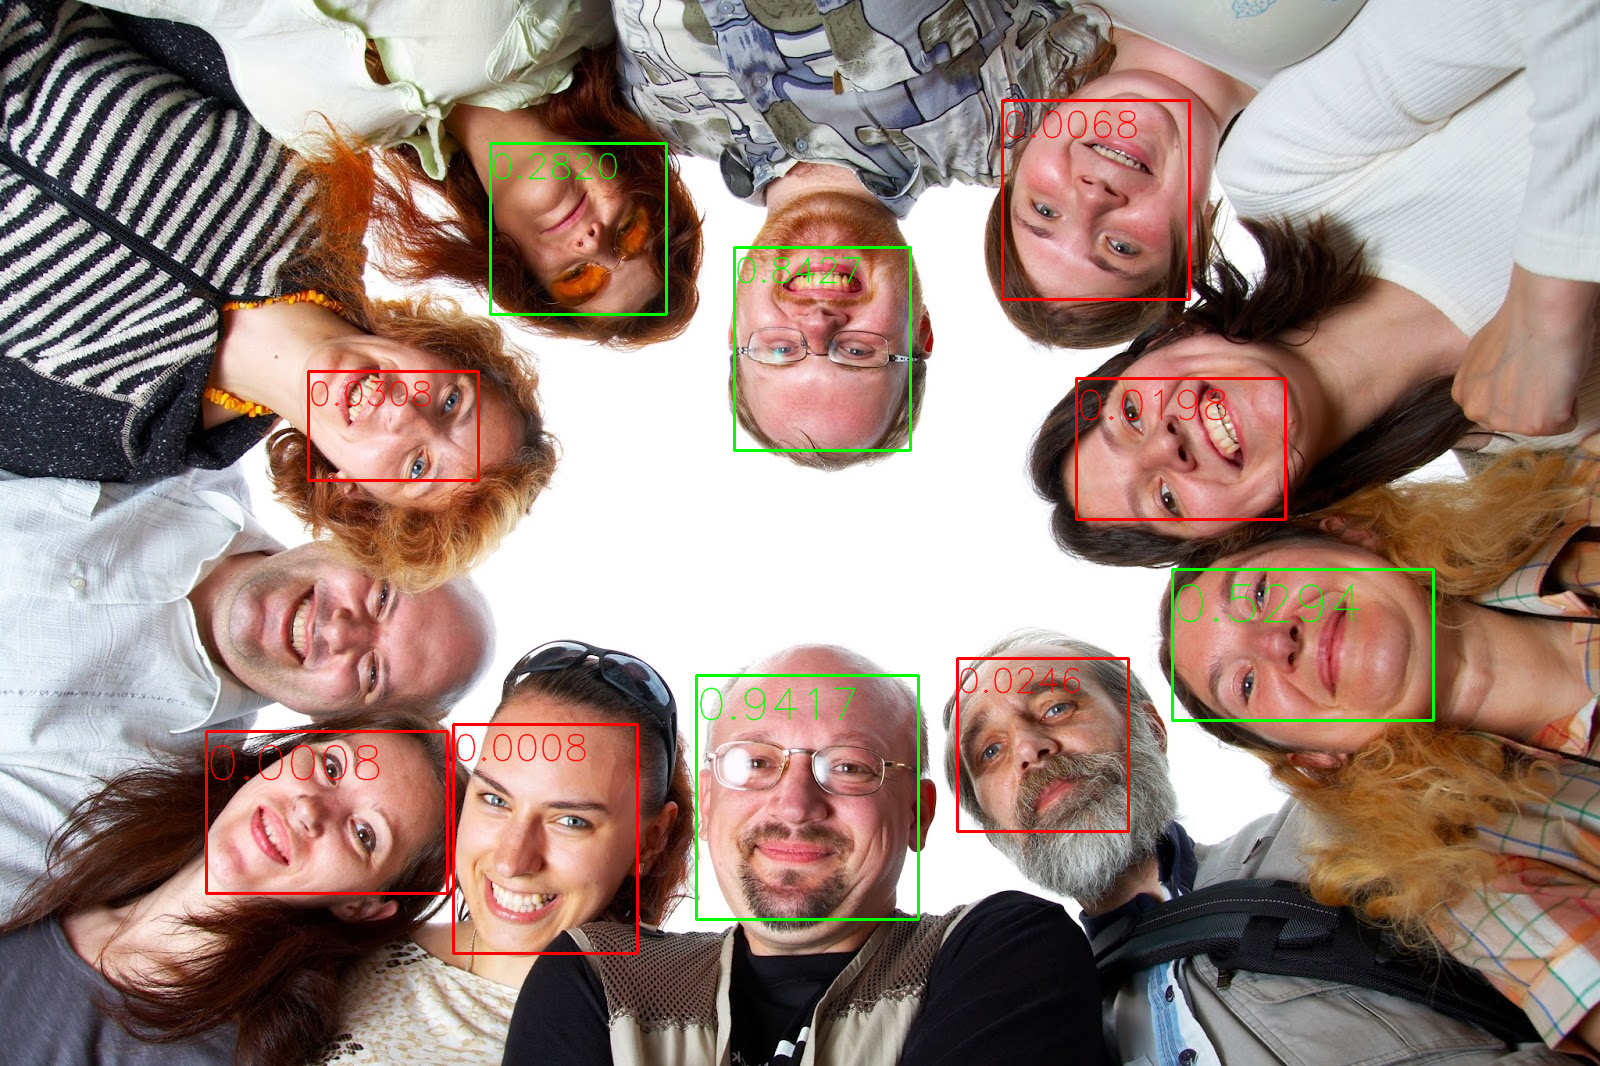

In [4]:
path_image = "faces.jpg"
img = cv.imread(path_image)
borders, imgs = crop_model.crop(img)

print_img = img.copy()
if len(borders) > 0:
    _, probas = predict_with_model(model, list(map(prepare_img, imgs)))

    for ccords, proba in zip(borders, probas[:, 1]):
        bbox = ccords[0:4].astype(np.int32)

        color = (0, 255, 0) if proba > threshold else (0, 0, 255)
        cv.putText(
            print_img,
            "{:1.4f}".format(proba),
            (bbox[0], int(bbox[1] + bbox[2] / 5)),
            cv.FONT_HERSHEY_SIMPLEX,
            bbox[2] / 150,
            color,
            1,
            cv.LINE_AA,
        )
        cv.rectangle(print_img, (bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3]), color, 2)

    draw_image_function(print_img)

0.94168144


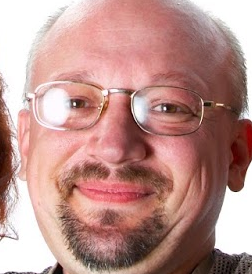

0.0008270978


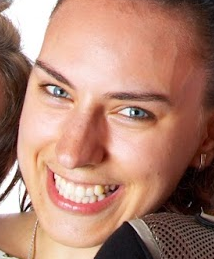

0.8427231


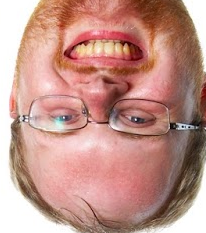

0.024610214


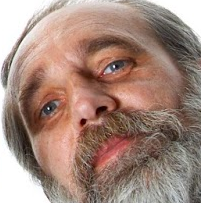

0.006825887


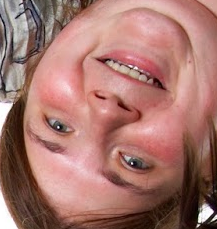

0.28196624


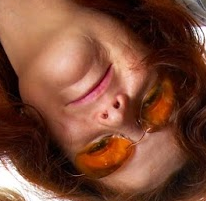

0.00079533027


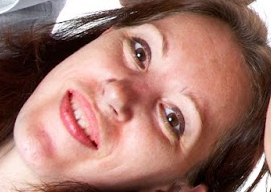

0.5293769


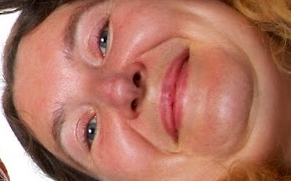

0.019830529


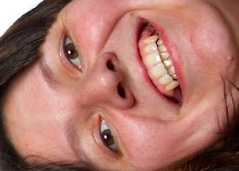

0.030813053


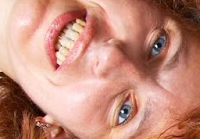

In [5]:
for proba, croped_img in zip(probas[:, 1], imgs):
    print(proba)
    # draw_image_function(cv.resize(croped_img, (100, int(croped_img.shape[0] / croped_img.shape[1] * 100))))
    draw_image_function(croped_img)